# VQE example on a kagome lattice

## 1- Preparing the model

### Importing libraries and creating the lattice model

In [1]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

TOKEN = "MY_TOKEN"

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

TOKEN = os.getenv('TOKEN')
# print(TOKEN)

In [3]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

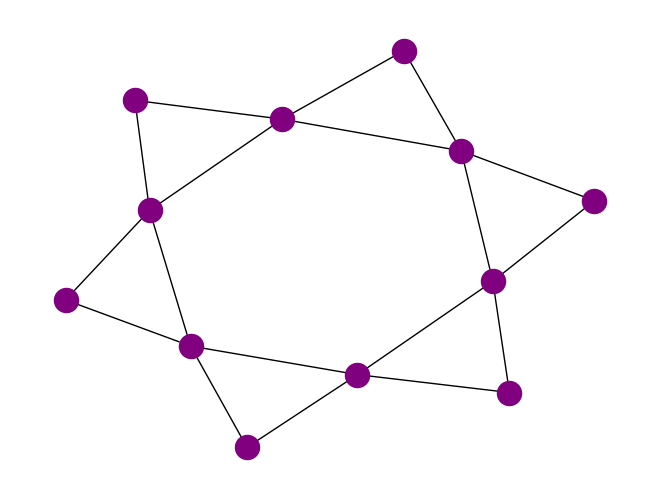

TypeError: PyGraph.from_adjacency_matrix() missing 1 required positional argument: 'matrix'

In [20]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()



### Converting the lattice model into a Hamiltonian

We use the structure of the lattice with a Heisenberg XXX model. For each edge we add a $XX + YY + ZZ$ term.

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [6]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy

In [30]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)
print(exact_result._eigenstates)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.]
ListOp([
  VectorStateFn(Statevector([ 2.03778755e-17-3.04847188e-17j,
                7.78304388e-18+5.81387404e-19j,
                1.12966068e-17+5.47973355e-18j, ...,
                5.44262865e-18-4.28299282e-18j,
               -3.90547434e-19-5.97557900e-20j,
               -6.96779801e-18+4.33684054e-18j],
              dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)))
])


In [36]:
type(exact_result.eigenstates)

qiskit.opflow.list_ops.list_op.ListOp

## 2- Running on a simulator

### Loading the IBM account

In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN,
                                  overwrite = True)
service = QiskitRuntimeService(channel='ibm_quantum')

#service.get_backend("ibmq_guadalupe")


In [9]:
# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()

### Adapting the model to the specific QPU

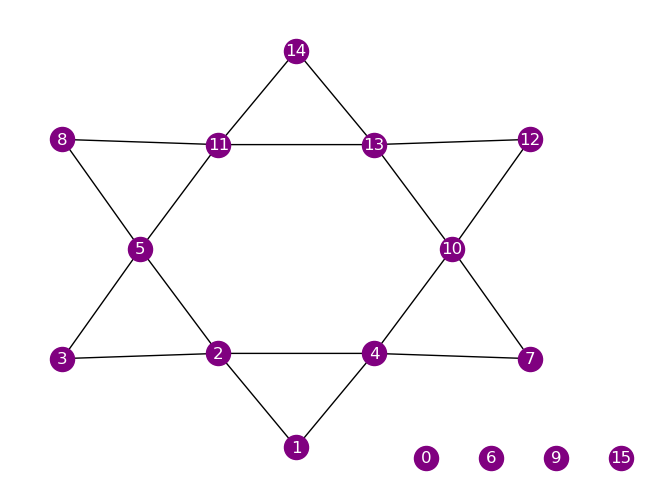

In [10]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [11]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

### Creating an ansatz

In [12]:
from qiskit.circuit.library import EfficientSU2
from ansatz import *

In [13]:

# ansatz = EfficientSU2(12, entanglement='linear', reps=1, skip_final_rotation_layer=True).decompose()
# ansatz.draw(fold=300)

ansatz = create_ansatz_4(12, 1)
ansatz.draw(fold = 300)

┌─────────┐                                                        
 q_0: ┤ Ry(θ_0) ├───■────────────────────────────────────────────────────
      ├─────────┤ ┌─┴─┐                                                  
 q_1: ┤ Ry(θ_1) ├─┤ X ├──■───────────────────────────────────────────────
      ├─────────┤ └───┘┌─┴─┐                                             
 q_2: ┤ Ry(θ_2) ├──────┤ X ├──■──────────────────────────────────────────
      ├─────────┤      └───┘┌─┴─┐                                        
 q_3: ┤ Ry(θ_3) ├───────────┤ X ├──■─────────────────────────────────────
      ├─────────┤           └───┘┌─┴─┐                                   
 q_4: ┤ Ry(θ_4) ├────────────────┤ X ├──■────────────────────────────────
      ├─────────┤                └───┘┌─┴─┐                              
 q_5: ┤ Ry(θ_5) ├─────────────────────┤ X ├──■───────────────────────────
      ├─────────┤                     └───┘┌─┴─┐                         
 q_6: ┤ Ry(θ_6) ├──────────────────────────┤ X ├──■──────────────────────
      ├─────────┤                          └───┘┌─┴─┐                    
 q_7: ┤ Ry(θ_7) ├───────────────────────────────┤ X ├──■─────────────────
      ├─────────┤                               └───┘┌─┴─┐               
 q_8: ┤ Ry(θ_8) ├────────────────────────────────────┤ X ├──■────────────
      ├─────────┤                                    └───┘┌─┴─┐          
 q_9: ┤ Ry(θ_9) ├─────────────────────────────────────────┤ X ├──■───────
      ├─────────┴┐                                        └───┘┌─┴─┐     
q_10: ┤ Ry(θ_10) ├─────────────────────────────────────────────┤ X ├──■──
      ├──────────┤                                             └───┘┌─┴─┐
q_11: ┤ Ry(θ_11) ├──────────────────────────────────────────────────┤ X ├
      └──────────┘                                                  └───┘

### Match qubit layout


In [14]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz, backend=noisy_sim, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('sx', 24), ('rz', 24), ('cx', 11)])
number of parameters in the circuit: 12


ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────
                ┌────┐┌─────────────┐ ┌────┐┌────────┐                                                       
       q_0 -> 1 ┤ √X ├┤ Rz(θ_0 + π) ├─┤ √X ├┤ Rz(3π) ├──■────────────────────────────────────────────────────
                ├────┤├─────────────┤ ├────┤├────────┤┌─┴─┐                                                  
       q_1 -> 2 ┤ √X ├┤ Rz(θ_1 + π) ├─┤ √X ├┤ Rz(3π) ├┤ X ├──■───────────────────────────────────────────────
                ├────┤├─────────────┤ ├────┤├────────┤└───┘┌─┴─┐                                             
       q_2 -> 3 ┤ √X ├┤ Rz(θ_2 + π) ├─┤ √X ├┤ Rz(3π) ├─────┤ X ├──■──────────────────────────────────────────
                ├────┤├─────────────┴┐├────┤├────────┤     └───┘  │                                     ┌───┐
      q_11 -> 4 ┤ √X ├┤ Rz(θ_11 + π) ├┤ √X ├┤ Rz(3π) ├────────────┼─────────────────────────────────────┤ X ├
                ├────┤├─────────────┬┘├────┤├────────┤          ┌─┴─┐                                   └─┬─┘
       q_3 -> 5 ┤ √X ├┤ Rz(θ_3 + π) ├─┤ √X ├┤ Rz(3π) ├──────────┤ X ├──■──────────────────────────────────┼──
                └────┘└─────────────┘ └────┘└────────┘          └───┘  │                                  │  
 ancilla_1 -> 6 ───────────────────────────────────────────────────────┼──────────────────────────────────┼──
                ┌────┐┌──────────────┐┌────┐┌────────┐                 │                           ┌───┐  │  
      q_10 -> 7 ┤ √X ├┤ Rz(θ_10 + π) ├┤ √X ├┤ Rz(3π) ├─────────────────┼───────────────────────────┤ X ├──■──
                ├────┤├─────────────┬┘├────┤├────────┤               ┌─┴─┐                         └─┬─┘     
       q_4 -> 8 ┤ √X ├┤ Rz(θ_4 + π) ├─┤ √X ├┤ Rz(3π) ├───────────────┤ X ├──■────────────────────────┼───────
                └────┘└─────────────┘ └────┘└────────┘               └───┘  │                        │       
 ancilla_2 -> 9 ────────────────────────────────────────────────────────────┼────────────────────────┼───────
                ┌────┐┌─────────────┐ ┌────┐┌────────┐                      │                 ┌───┐  │       
      q_9 -> 10 ┤ √X ├┤ Rz(θ_9 + π) ├─┤ √X ├┤ Rz(3π) ├──────────────────────┼─────────────────┤ X ├──■───────
                ├────┤├─────────────┤ ├────┤├────────┤                    ┌─┴─┐               └─┬─┘          
      q_5 -> 11 ┤ √X ├┤ Rz(θ_5 + π) ├─┤ √X ├┤ Rz(3π) ├────────────────────┤ X ├──■──────────────┼────────────
                ├────┤├─────────────┤ ├────┤├────────┤                    └───┘  │       ┌───┐  │            
      q_8 -> 12 ┤ √X ├┤ Rz(θ_8 + π) ├─┤ √X ├┤ Rz(3π) ├───────────────────────────┼───────┤ X ├──■────────────
                ├────┤├─────────────┤ ├────┤├────────┤                           │  ┌───┐└─┬─┘               
      q_7 -> 13 ┤ √X ├┤ Rz(θ_7 + π) ├─┤ √X ├┤ Rz(3π) ├───────────────────────────┼──┤ X ├──■─────────────────
                ├────┤├─────────────┤ ├────┤├────────┤                         ┌─┴─┐└─┬─┘                    
      q_6 -> 14 ┤ √X ├┤ Rz(θ_6 + π) ├─┤ √X ├┤ Rz(3π) ├─────────────────────────┤ X ├──■──────────────────────
                └────┘└─────────────┘ └────┘└────────┘                         └───┘                         
ancilla_3 -> 15 ─────────────────────────────────────────────────────────────────────────────────────────────

### Choose a classical optimizer

In [15]:
from qiskit.algorithms.optimizers import NFT

optimizer = NFT(maxiter=50)

### Define custom VQE program

In [16]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.zeros((self._circuit.num_parameters))
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


In [17]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

### Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [18]:
from qiskit.primitives import Estimator

In [19]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 102,
    'eigenstate': None,
    'eigenvalue': -17.999909537339704,
    'optimal_circuit': None,
    'optimal_parameters': array([1.57079633, 3.14159265, 4.71238754, 3.14159265, 4.71238898,
       3.14146085, 1.57121328, 3.14965648, 4.70884748, 3.14152678,
       1.57079737, 3.14159265]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 26.73


In [40]:
print(result.optimal_parameters / np.pi)

[0.5        1.         1.49999954 1.         1.5        0.99995805
 0.50013272 1.00256679 1.4988727  0.99997903 0.50000033 1.        ]


In [41]:
num_qubits = 12

qc = QuantumCircuit(num_qubits)
j = 0
for qubit in range(num_qubits):
    qc.ry(Parameter('θ_' + str(j)), qubit)
    j += 1
ansatz = qc
        

In [47]:
#ALL IN A SINGLE CELL
res = []
# ansatz = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
for i in range(1):
        ansatz = create_ansatz_4(12, i + 1)
        # ansatz = EfficientSU2(12, entanglement='linear', reps=i+1, skip_final_rotation_layer=True).decompose()

        q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
        ansatz_opt = transpile(ansatz, backend=noisy_sim, initial_layout=q_layout)

        intermediate_info = []
        def callback(value):
                intermediate_info.append(value)

        optimizer = NFT(maxiter=50)

        estimator = Estimator([ansatz_opt], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result.eigenvalue)
        print(f'execution time (s): {end - start:.2f}')
        res.append(result)



-17.999909537339704
execution time (s): 22.33


In [44]:
ansatz_opt.draw()


ancilla_0 -> 0 ──────────────────────────────────────
                ┌────┐┌─────────────┐ ┌────┐┌────────┐
       q_0 -> 1 ┤ √X ├┤ Rz(θ_0 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
       q_1 -> 2 ┤ √X ├┤ Rz(θ_1 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
       q_2 -> 3 ┤ √X ├┤ Rz(θ_2 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┴┐├────┤├────────┤
      q_11 -> 4 ┤ √X ├┤ Rz(θ_11 + π) ├┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┬┘├────┤├────────┤
       q_3 -> 5 ┤ √X ├┤ Rz(θ_3 + π) ├─┤ √X ├┤ Rz(3π) ├
                └────┘└─────────────┘ └────┘└────────┘
 ancilla_1 -> 6 ──────────────────────────────────────
                ┌────┐┌──────────────┐┌────┐┌────────┐
      q_10 -> 7 ┤ √X ├┤ Rz(θ_10 + π) ├┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┬┘├────┤├────────┤
       q_4 -> 8 ┤ √X ├┤ Rz(θ_4 + π) ├─┤ √X ├┤ Rz(3π) ├
                └────┘└─────────────┘ └────┘└────────┘
 ancilla_2 -> 9 ──────────────────────────────────────
                ┌────┐┌─────────────┐ ┌────┐┌────────┐
      q_9 -> 10 ┤ √X ├┤ Rz(θ_9 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
      q_5 -> 11 ┤ √X ├┤ Rz(θ_5 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
      q_8 -> 12 ┤ √X ├┤ Rz(θ_8 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
      q_7 -> 13 ┤ √X ├┤ Rz(θ_7 + π) ├─┤ √X ├┤ Rz(3π) ├
                ├────┤├─────────────┤ ├────┤├────────┤
      q_6 -> 14 ┤ √X ├┤ Rz(θ_6 + π) ├─┤ √X ├┤ Rz(3π) ├
                └────┘└─────────────┘ └────┘└────────┘
ancilla_3 -> 15 ──────────────────────────────────────

### Results analysis

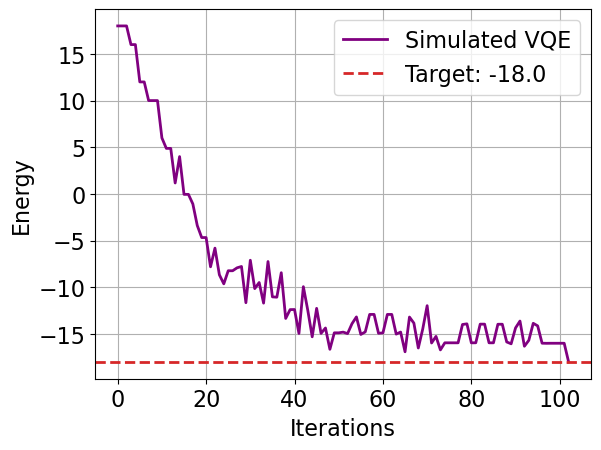

In [48]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [30]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -17.9999095373
Relative error: 0.00000503


### Creating the RetryEstimator

In [74]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

### Example with statevector_simulator

In [75]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

service = QiskitRuntimeService(channel='ibm_quantum')

In [84]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [85]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_real(value):
        intermediate_info_sim_backend.append(value)

In [86]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

AttributeError: module 'signal' has no attribute 'SIGALRM'

In [38]:
# # Setup Estimator (standard method)
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # Set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
#     # Run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

execution time (s): 286.40


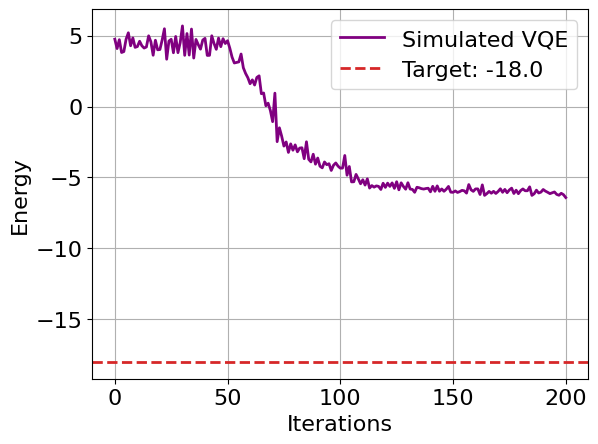

In [39]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [40]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -6.4140000000
Relative error: 0.64366667


### Qiskit runtime Real backend (ibmq_guadalupe)


In [57]:
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)

backend = 'ibmq_guadalupe'

In [58]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [ ]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [ ]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

In [59]:
# # Setup Estimator
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
#     # run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

execution time (s): 6805.67


### Results analysis


In [31]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

NameError: name 'intermediate_info_real_backend' is not defined

In [137]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

Expected ground state energy: -4.5000000000
Computed ground state energy: -1.1372500000
Relative error: 74.7277777778 %
